In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.callbacks import EarlyStopping,CSVLogger
from tensorflow.keras import backend as K
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt
import numpy as np
from equation_as2 import equation

C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# add to the top of your code under import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
#import dataset
train_x = pickle.load(open('./Data/train_pairs.pickle','rb'))
train_y = pickle.load(open('./Data/train_y.pickle','rb'))
test_x1 = pickle.load(open('./Data/test_pairs1.pickle','rb'))
test_y1 = pickle.load(open('./Data/test_y1.pickle','rb'))
test_x2 = pickle.load(open('./Data/test_pairs2.pickle','rb'))
test_y2 = pickle.load(open('./Data/test_y2.pickle','rb'))
test_x3 = pickle.load(open('./Data/test_pairs3.pickle','rb'))
test_y3 = pickle.load(open('./Data/test_y3.pickle','rb'))

In [4]:
train_x = train_x.astype('float32')
test_x1 = test_x1.astype('float32')
test_x2 = test_x2.astype('float32')
test_x3 = test_x3.astype('float32')
train_x /= 255
test_x1 /= 255
test_x2 /= 255
test_x3 /= 255

In [5]:
img_rows, img_cols = train_x.shape[2:4]
train_x = train_x.reshape(train_x.shape[0], 2 ,img_rows, img_cols, 1)
test_x1 = test_x1.reshape(test_x1.shape[0],2, img_rows, img_cols, 1)
test_x2 = test_x2.reshape(test_x2.shape[0],2, img_rows, img_cols, 1)
test_x3 = test_x3.reshape(test_x3.shape[0],2, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [6]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    output = Dense(128, activation=tf.nn.relu,name = 'embeding')(x) 
    
    return Model(input_tensor, output)

In [7]:
def create_base_network_1(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [8]:
def siamese_model(input_shape,cnn_base_network):
    base_network = cnn_base_network
    base_network.summary()
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    # because we re-use the same instance `base_network`,
    # the weights of the network
    # will be shared across the two branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(equation.euclidean_distance,
                      output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

    model = Model([input_a, input_b], distance)
    model.summary()
    
    return model

In [9]:
def plot_loss_accuracy(history,parameter):
    print("Tuning :"+parameter)
    loss = history.history['loss'].copy()
    val_loss= history.history['val_loss'].copy()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss','Validation loss'])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    accuracy = history.history['accuracy'].copy()
    val_accuracy = history.history['val_accuracy'].copy()
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.legend(['accuracy','val_accuracy'])
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

In [10]:
def evaluate_test_accuracy(model,model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3):
    print("Tuning :"+model_name)
    pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
    pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
    pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

    te_acc1 = equation.compute_accuracy(test_y1, pred1)
    te_acc2 = equation.compute_accuracy(test_y2, pred2)
    te_acc3 = equation.compute_accuracy(test_y3, pred3)
    print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
    print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
    print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

    model.save('./Data/model'+model_name+'.h5')

In [11]:
#set margin
Ass2_Equation = equation(0.7)

### Tuning Hyperparameters

In [12]:
#check fully connect layer embedding 1

In [13]:
select_base_arch=create_base_network(input_shape)
model=siamese_model(input_shape,select_base_arch)

W1007 12:00:43.838460 15040 deprecation.py:506] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          18496 

In [14]:
model_name='lr_1e-4_emb_1'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model/Model_'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

W1007 12:00:44.276873 15040 deprecation.py:323] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 146us/sample - loss: 4.2593 - accuracy: 0.5073 - val_loss: 0.2938 - val_accuracy: 0.4543
Epoch 2/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.2257 - accuracy: 0.5042 - val_loss: 0.3007 - val_accuracy: 0.4382
Epoch 3/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.2098 - accuracy: 0.5082 - val_loss: 0.3420 - val_accuracy: 0.4161
Epoch 4/200
60145/60145 [==============================] - 7s 113us/sample - loss: 0.2002 - accuracy: 0.5116 - val_loss: 0.3229 - val_accuracy: 0.4145
Epoch 5/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.1923 - accuracy: 0.5161 - val_loss: 0.3311 - val_accuracy: 0.4146
Epoch 6/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.1860 - accuracy: 0.5178 - val_loss: 0.3334 - val_accuracy: 0.4149
Epoch 7/200
60145/60145 [====================

Tuning :lr_1e-4_emb_1


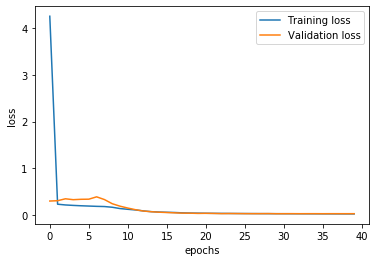

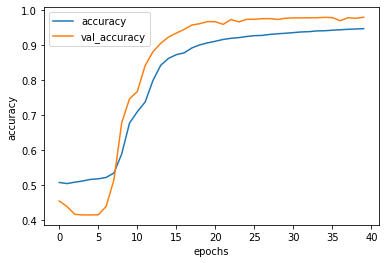

Tuning :lr_1e-4_emb_1
* Accuracy on test1 set: 92.97%
* Accuracy on test2 set: 67.25%
* Accuracy on test3 set: 80.78%


In [15]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [16]:
select_base_arch=create_base_network_1(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [17]:
model_name='lr_1e-4_emb_2'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model/Model_'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 127us/sample - loss: 1.8866 - accuracy: 0.5329 - val_loss: 0.1852 - val_accuracy: 0.6014
Epoch 2/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.1345 - accuracy: 0.6054 - val_loss: 0.1137 - val_accuracy: 0.7622
Epoch 3/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0876 - accuracy: 0.7505 - val_loss: 0.0710 - val_accuracy: 0.8558
Epoch 4/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0638 - accuracy: 0.8262 - val_loss: 0.0589 - val_accuracy: 0.8885
Epoch 5/200
60145/60145 [==============================] - 7s 119us/sample - loss: 0.0552 - accuracy: 0.8512 - val_loss: 0.0535 - val_accuracy: 0.9065
Epoch 6/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.0484 - accuracy: 0.8596 - val_loss: 0.0435 - val_accuracy: 0.9239
Epoch 7/200
60145/60145 [====================

Tuning :lr_1e-4_emb_2


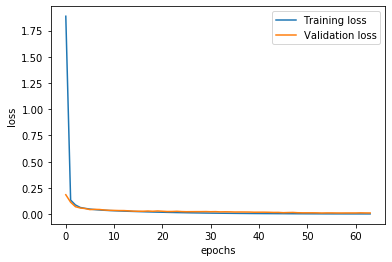

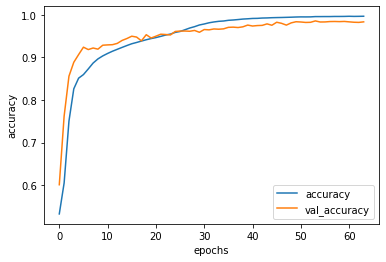

Tuning :lr_1e-4_emb_2
* Accuracy on test1 set: 95.95%
* Accuracy on test2 set: 64.54%
* Accuracy on test3 set: 81.11%


In [18]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [19]:
#drop out

In [20]:
def create_base_network_drop(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [21]:
select_base_arch=create_base_network_drop(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [22]:
model_name='relu_lr1e-4_dropout'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 134us/sample - loss: 2.9121 - accuracy: 0.5155 - val_loss: 0.1617 - val_accuracy: 0.5139
Epoch 2/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.1736 - accuracy: 0.5369 - val_loss: 0.0654 - val_accuracy: 0.8312
Epoch 3/200
60145/60145 [==============================] - 7s 122us/sample - loss: 0.1024 - accuracy: 0.6963 - val_loss: 0.0414 - val_accuracy: 0.8959
Epoch 4/200
60145/60145 [==============================] - 7s 122us/sample - loss: 0.0706 - accuracy: 0.7853 - val_loss: 0.0353 - val_accuracy: 0.9051
Epoch 5/200
60145/60145 [==============================] - 7s 122us/sample - loss: 0.0596 - accuracy: 0.8154 - val_loss: 0.0321 - val_accuracy: 0.9069
Epoch 6/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.0540 - accuracy: 0.8301 - val_loss: 0.0287 - val_accuracy: 0.9121
Epoch 7/200
60145/60145 [====================

60145/60145 [==============================] - 7s 124us/sample - loss: 0.0067 - accuracy: 0.9831 - val_loss: 0.0089 - val_accuracy: 0.9901
Epoch 108/200
60145/60145 [==============================] - 7s 123us/sample - loss: 0.0067 - accuracy: 0.9833 - val_loss: 0.0097 - val_accuracy: 0.9897
Epoch 109/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.0066 - accuracy: 0.9837 - val_loss: 0.0093 - val_accuracy: 0.9904
Epoch 110/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.0066 - accuracy: 0.9832 - val_loss: 0.0093 - val_accuracy: 0.9907
Epoch 111/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.0064 - accuracy: 0.9847 - val_loss: 0.0090 - val_accuracy: 0.9891
Epoch 112/200
60145/60145 [==============================] - 7s 123us/sample - loss: 0.0065 - accuracy: 0.9842 - val_loss: 0.0094 - val_accuracy: 0.9884
Epoch 113/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.0064 - ac

Tuning :relu_lr1e-4_dropout


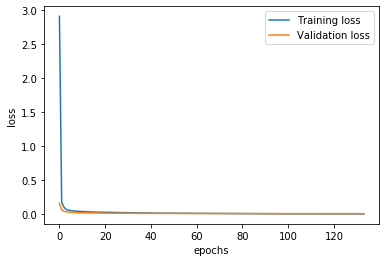

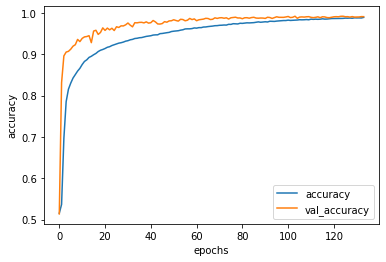

Tuning :relu_lr1e-4_dropout
* Accuracy on test1 set: 96.37%
* Accuracy on test2 set: 69.29%
* Accuracy on test3 set: 82.89%


In [23]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [24]:
def create_base_network_drop_2(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation=tf.nn.relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [25]:
select_base_arch=create_base_network_drop_2(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [26]:
model_name='relu_lr1e-4_dropout_after_flat'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 131us/sample - loss: 3.0414 - accuracy: 0.5085 - val_loss: 0.2124 - val_accuracy: 0.5121
Epoch 2/200
60145/60145 [==============================] - 7s 119us/sample - loss: 0.2016 - accuracy: 0.5073 - val_loss: 0.1942 - val_accuracy: 0.4959
Epoch 3/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.1628 - accuracy: 0.5480 - val_loss: 0.1068 - val_accuracy: 0.6763
Epoch 4/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.1054 - accuracy: 0.7028 - val_loss: 0.0791 - val_accuracy: 0.7622
Epoch 5/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.0836 - accuracy: 0.7553 - val_loss: 0.0486 - val_accuracy: 0.8845
Epoch 6/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.0709 - accuracy: 0.7832 - val_loss: 0.0283 - val_accuracy: 0.9389
Epoch 7/200
60145/60145 [====================

Tuning :relu_lr1e-4_dropout_after_flat


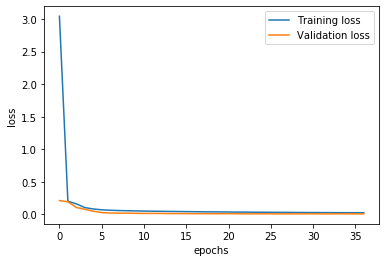

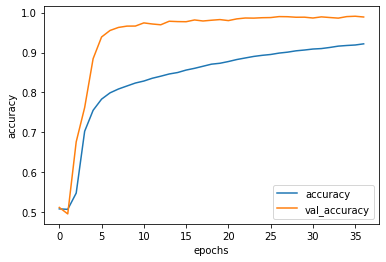

Tuning :relu_lr1e-4_dropout_after_flat
* Accuracy on test1 set: 91.96%
* Accuracy on test2 set: 65.80%
* Accuracy on test3 set: 80.12%


In [27]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [28]:
def create_base_network_drop_3(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.relu,name = 'embeding')(x) 
    x = Dropout(0.2)(x)
    output = Dense(128, activation=tf.nn.relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [29]:
select_base_arch=create_base_network_drop_3(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [30]:
model_name='relu_lr1e-4_dropout_3'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 131us/sample - loss: 2.2699 - accuracy: 0.5116 - val_loss: 0.1817 - val_accuracy: 0.4844
Epoch 2/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.1692 - accuracy: 0.5353 - val_loss: 0.1316 - val_accuracy: 0.6647
Epoch 3/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.1413 - accuracy: 0.5622 - val_loss: 0.0978 - val_accuracy: 0.6319
Epoch 4/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.1225 - accuracy: 0.5991 - val_loss: 0.0793 - val_accuracy: 0.6585
Epoch 5/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.1093 - accuracy: 0.6422 - val_loss: 0.0606 - val_accuracy: 0.7228
Epoch 6/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0969 - accuracy: 0.6781 - val_loss: 0.0475 - val_accuracy: 0.7680
Epoch 7/200
60145/60145 [====================

Tuning :relu_lr1e-4_dropout_3


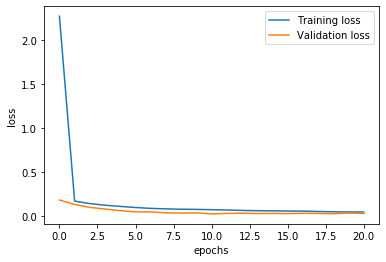

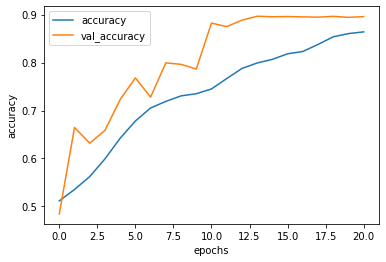

Tuning :relu_lr1e-4_dropout_3
* Accuracy on test1 set: 89.24%
* Accuracy on test2 set: 71.30%
* Accuracy on test3 set: 79.70%


In [31]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [ ]:
##CHECK MARGIN

Learning rate

In [49]:
select_base_arch=create_base_network_drop(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_20 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [50]:
model_name='lr_1e-4'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model/Model_'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 143us/sample - loss: 3.6476 - accuracy: 0.5058 - val_loss: 0.2143 - val_accuracy: 0.5052
Epoch 2/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.2034 - accuracy: 0.5134 - val_loss: 0.1899 - val_accuracy: 0.5184
Epoch 3/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.1715 - accuracy: 0.5525 - val_loss: 0.1349 - val_accuracy: 0.6288
Epoch 4/200
60145/60145 [==============================] - 7s 119us/sample - loss: 0.1285 - accuracy: 0.6652 - val_loss: 0.0972 - val_accuracy: 0.7572
Epoch 5/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.0991 - accuracy: 0.7286 - val_loss: 0.0688 - val_accuracy: 0.7912
Epoch 6/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0771 - accuracy: 0.7741 - val_loss: 0.0577 - val_accuracy: 0.8423
Epoch 7/200
60145/60145 [====================

Tuning :lr_1e-4


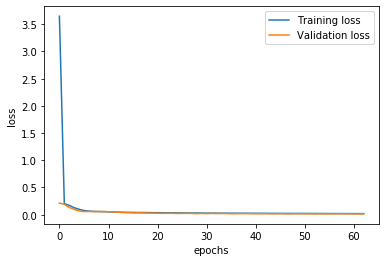

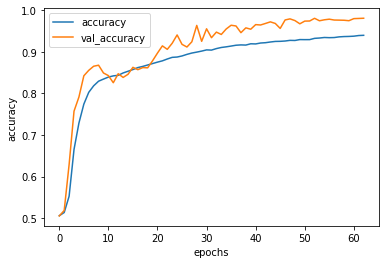

Tuning :lr_1e-4
* Accuracy on test1 set: 93.68%
* Accuracy on test2 set: 69.72%
* Accuracy on test3 set: 81.53%


In [51]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [52]:
select_base_arch=create_base_network_drop(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_22 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [53]:
model_name='lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 143us/sample - loss: 0.4325 - accuracy: 0.7284 - val_loss: 0.0265 - val_accuracy: 0.9050
Epoch 2/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0430 - accuracy: 0.8605 - val_loss: 0.0229 - val_accuracy: 0.9402
Epoch 3/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0370 - accuracy: 0.8859 - val_loss: 0.0220 - val_accuracy: 0.9245
Epoch 4/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0326 - accuracy: 0.9052 - val_loss: 0.0192 - val_accuracy: 0.9541
Epoch 5/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.0295 - accuracy: 0.9135 - val_loss: 0.0186 - val_accuracy: 0.9530
Epoch 6/200
60145/60145 [==============================] - 7s 122us/sample - loss: 0.0268 - accuracy: 0.9201 - val_loss: 0.0170 - val_accuracy: 0.9618
Epoch 7/200
60145/60145 [====================

Tuning :lr1e-3


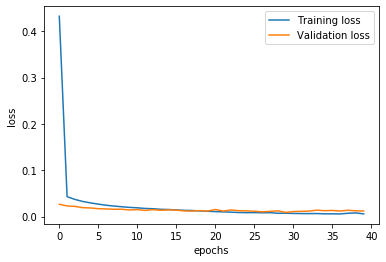

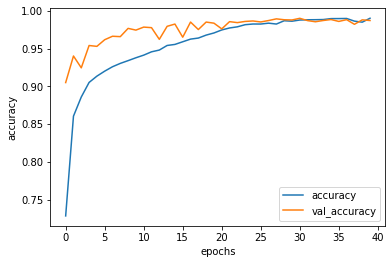

In [54]:
plot_loss_accuracy(history, model_name)

In [55]:
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

Tuning :lr1e-3
* Accuracy on test1 set: 96.81%
* Accuracy on test2 set: 65.47%
* Accuracy on test3 set: 81.85%


In [43]:
select_base_arch=create_base_network_drop(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_16 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [44]:
model_name='lr3e-3'
# train
epochs = 200
adam = Adam(learning_rate=3e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 147us/sample - loss: 0.3180 - accuracy: 0.7868 - val_loss: 0.0272 - val_accuracy: 0.9131
Epoch 2/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.0357 - accuracy: 0.9003 - val_loss: 0.0265 - val_accuracy: 0.9594
Epoch 3/200
60145/60145 [==============================] - 7s 123us/sample - loss: 0.0311 - accuracy: 0.9148 - val_loss: 0.0242 - val_accuracy: 0.9565
Epoch 4/200
60145/60145 [==============================] - 7s 123us/sample - loss: 0.0287 - accuracy: 0.9222 - val_loss: 0.0196 - val_accuracy: 0.9438
Epoch 5/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.0265 - accuracy: 0.9267 - val_loss: 0.0217 - val_accuracy: 0.9458
Epoch 6/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.0251 - accuracy: 0.9312 - val_loss: 0.0153 - val_accuracy: 0.9830
Epoch 7/200
60145/60145 [====================

Tuning :lr3e-3


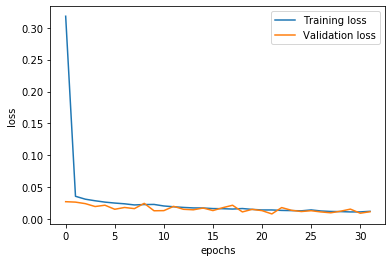

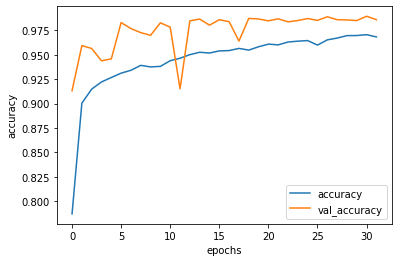

Tuning :lr3e-3
* Accuracy on test1 set: 96.60%
* Accuracy on test2 set: 67.18%
* Accuracy on test3 set: 81.87%


In [45]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [46]:
select_base_arch=create_base_network_drop(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_18 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [47]:
model_name='lr1e+3'
# train
epochs = 200
adam = Adam(learning_rate=1e+3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 147us/sample - loss: 565040044768111034368.0000 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.4974
Epoch 2/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.4997
Epoch 3/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.4991
Epoch 4/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.4980
Epoch 5/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.4997
Epoch 6/200
60145/60145 [==============================] - 7s 125us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.4969
Epoch 7/200
60145/60145 [

Tuning :lr1e+3


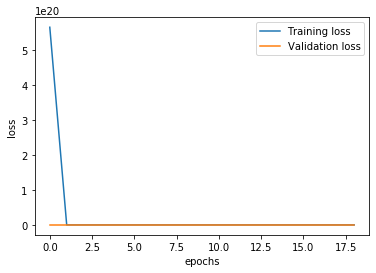

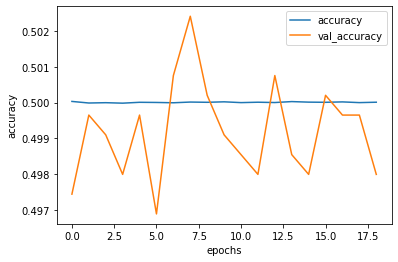

Tuning :lr1e+3
* Accuracy on test1 set: 50.00%
* Accuracy on test2 set: 50.00%
* Accuracy on test3 set: 50.00%


In [48]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

leaky_RELU

In [56]:
def create_base_network_leaky_relu(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [57]:
select_base_arch=create_base_network_leaky_relu(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_24 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [58]:
model_name='leaky_relu_lr1e-4'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 154us/sample - loss: 4.3020 - accuracy: 0.5002 - val_loss: 0.1353 - val_accuracy: 0.6963
Epoch 2/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.3307 - accuracy: 0.5102 - val_loss: 0.1039 - val_accuracy: 0.6660
Epoch 3/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.2102 - accuracy: 0.5507 - val_loss: 0.0937 - val_accuracy: 0.5844
Epoch 4/200
60145/60145 [==============================] - 8s 129us/sample - loss: 0.1621 - accuracy: 0.5988 - val_loss: 0.0755 - val_accuracy: 0.6643
Epoch 5/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.1447 - accuracy: 0.6358 - val_loss: 0.0638 - val_accuracy: 0.7577
Epoch 6/200
60145/60145 [==============================] - 8s 129us/sample - loss: 0.1324 - accuracy: 0.6730 - val_loss: 0.0564 - val_accuracy: 0.8104
Epoch 7/200
60145/60145 [====================

Tuning :leaky_relu_lr1e-4


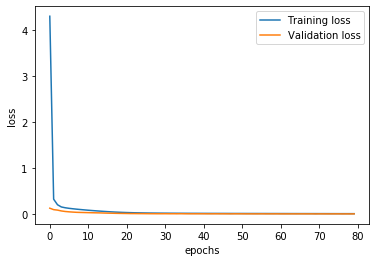

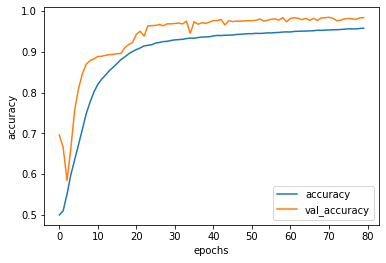

Tuning :leaky_relu_lr1e-4
* Accuracy on test1 set: 95.33%
* Accuracy on test2 set: 70.71%
* Accuracy on test3 set: 83.74%


In [59]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [60]:
select_base_arch=create_base_network_leaky_relu(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_26 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [61]:
model_name='leaky_relu_lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 157us/sample - loss: 0.6477 - accuracy: 0.5728 - val_loss: 0.0451 - val_accuracy: 0.8726
Epoch 2/200
60145/60145 [==============================] - 8s 133us/sample - loss: 0.1034 - accuracy: 0.7966 - val_loss: 0.0356 - val_accuracy: 0.8941
Epoch 3/200
60145/60145 [==============================] - 8s 134us/sample - loss: 0.0756 - accuracy: 0.8625 - val_loss: 0.0286 - val_accuracy: 0.8986
Epoch 4/200
60145/60145 [==============================] - 8s 132us/sample - loss: 0.0604 - accuracy: 0.8833 - val_loss: 0.0254 - val_accuracy: 0.9205
Epoch 5/200
60145/60145 [==============================] - 9s 153us/sample - loss: 0.0510 - accuracy: 0.8929 - val_loss: 0.0224 - val_accuracy: 0.9082
Epoch 6/200
60145/60145 [==============================] - 8s 137us/sample - loss: 0.0445 - accuracy: 0.9014 - val_loss: 0.0212 - val_accuracy: 0.9267
Epoch 7/200
60145/60145 [====================

Tuning :leaky_relu_lr1e-3


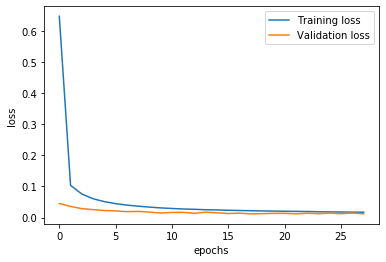

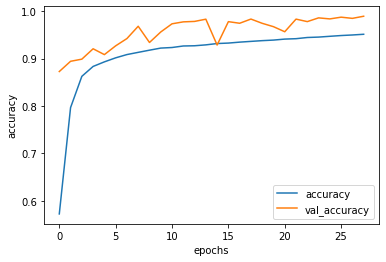

Tuning :leaky_relu_lr1e-3
* Accuracy on test1 set: 96.20%
* Accuracy on test2 set: 71.98%
* Accuracy on test3 set: 84.11%


In [62]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [63]:
#ELU

In [68]:
def create_base_network_elu(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.elu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.elu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.elu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.elu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.elu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.elu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [69]:
select_base_arch=create_base_network_elu(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_30 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [70]:
model_name='ELU_lr1e-4'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 144us/sample - loss: 5.5569 - accuracy: 0.5012 - val_loss: 0.1181 - val_accuracy: 0.6709
Epoch 2/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.2720 - accuracy: 0.5315 - val_loss: 0.0864 - val_accuracy: 0.5651
Epoch 3/200
60145/60145 [==============================] - 7s 115us/sample - loss: 0.1266 - accuracy: 0.6740 - val_loss: 0.0471 - val_accuracy: 0.8542
Epoch 4/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0884 - accuracy: 0.7823 - val_loss: 0.0397 - val_accuracy: 0.8854
Epoch 5/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0701 - accuracy: 0.8148 - val_loss: 0.0355 - val_accuracy: 0.8899
Epoch 6/200
60145/60145 [==============================] - 7s 115us/sample - loss: 0.0605 - accuracy: 0.8304 - val_loss: 0.0324 - val_accuracy: 0.8923
Epoch 7/200
60145/60145 [====================

Tuning :ELU_lr1e-4


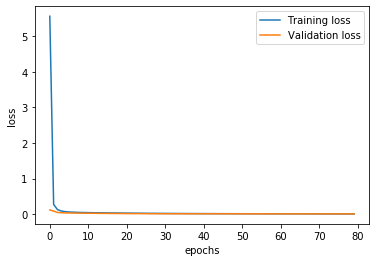

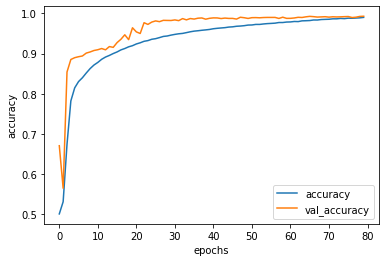

Tuning :ELU_lr1e-4
* Accuracy on test1 set: 96.74%
* Accuracy on test2 set: 68.44%
* Accuracy on test3 set: 83.47%


In [71]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [72]:
select_base_arch=create_base_network_elu(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_32 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [73]:
model_name='ELU_lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 147us/sample - loss: 0.6718 - accuracy: 0.7402 - val_loss: 0.0295 - val_accuracy: 0.8992
Epoch 2/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0467 - accuracy: 0.8550 - val_loss: 0.0255 - val_accuracy: 0.9249
Epoch 3/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0389 - accuracy: 0.8881 - val_loss: 0.0223 - val_accuracy: 0.9478
Epoch 4/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.0347 - accuracy: 0.9029 - val_loss: 0.0189 - val_accuracy: 0.9533
Epoch 5/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.0316 - accuracy: 0.9117 - val_loss: 0.0168 - val_accuracy: 0.9710
Epoch 6/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.0293 - accuracy: 0.9183 - val_loss: 0.0167 - val_accuracy: 0.9707
Epoch 7/200
60145/60145 [====================

Tuning :ELU_lr1e-3


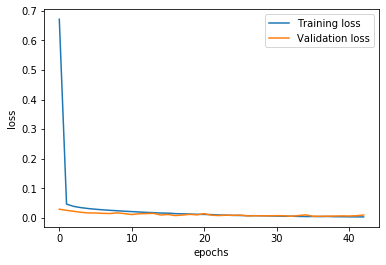

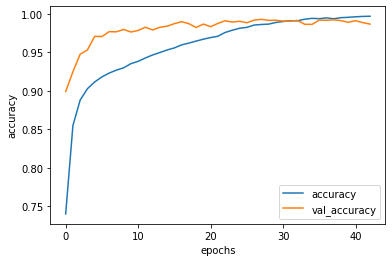

Tuning :ELU_lr1e-3
* Accuracy on test1 set: 96.73%
* Accuracy on test2 set: 65.75%
* Accuracy on test3 set: 82.23%


In [74]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [75]:
def create_base_network_leaky_relu_no_drop(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [76]:
select_base_arch=create_base_network_leaky_relu_no_drop(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_34 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [77]:
model_name='leaky_relu_no_drop_lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 10s 159us/sample - loss: 0.3042 - accuracy: 0.8313 - val_loss: 0.0375 - val_accuracy: 0.9619
Epoch 2/200
60145/60145 [==============================] - 8s 129us/sample - loss: 0.0414 - accuracy: 0.9036 - val_loss: 0.0254 - val_accuracy: 0.9714
Epoch 3/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.0348 - accuracy: 0.9174 - val_loss: 0.0221 - val_accuracy: 0.9707
Epoch 4/200
60145/60145 [==============================] - 8s 132us/sample - loss: 0.0319 - accuracy: 0.9219 - val_loss: 0.0168 - val_accuracy: 0.9750
Epoch 5/200
60145/60145 [==============================] - 8s 131us/sample - loss: 0.0300 - accuracy: 0.9252 - val_loss: 0.0157 - val_accuracy: 0.9814
Epoch 6/200
60145/60145 [==============================] - 8s 131us/sample - loss: 0.0281 - accuracy: 0.9288 - val_loss: 0.0144 - val_accuracy: 0.9829
Epoch 7/200
60145/60145 [===================

Tuning :leaky_relu_no_drop_lr1e-3


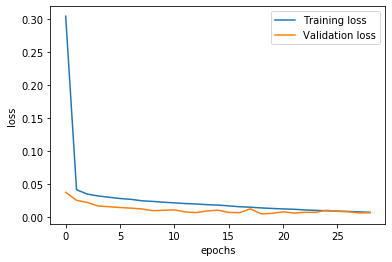

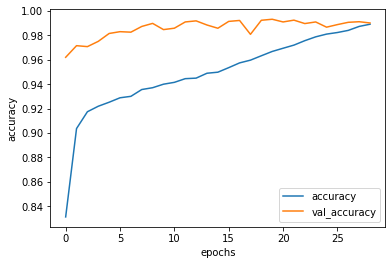

Tuning :leaky_relu_no_drop_lr1e-3
* Accuracy on test1 set: 96.83%
* Accuracy on test2 set: 67.48%
* Accuracy on test3 set: 82.67%


In [78]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [ ]:
Tuning :leaky_relu_lr1e-4
* Accuracy on test1 set: 95.33%
* Accuracy on test2 set: 70.71%
* Accuracy on test3 set: 83.74%

In [ ]:
Tuning :leaky_relu_lr1e-3
* Accuracy on test1 set: 96.20%
* Accuracy on test2 set: 71.98%
* Accuracy on test3 set: 84.11%